In [1]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import LinearSVCSummary
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split

First thing we need to do is to check, if the dataset is balanced or not. If it is, then we can continue to use spark and MLlib on said dataset. However, if the dataset is inbalanced, we then need to balance it using some method of oversampling or undersampling.

not a fraud: 99.87 % of the dataset
fraud: 0.13 % of the dataset
0    6354407
1       8213
Name: isFraud, dtype: int64


<AxesSubplot:xlabel='isFraud', ylabel='count'>

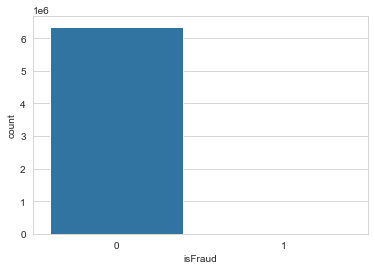

In [2]:
df = pd.read_csv("dataset.csv")

print('not a fraud:', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('fraud:', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
print(df['isFraud'].value_counts())
sns.set_style('whitegrid')
sns.countplot(x='isFraud',data=df)

As we can see, the dataset is very inbalanced. This is most probably due to it being synthetic dataset that was made for some specific purpose. We now have to balance it to guarantee that the methods of mllib that we will be using later will yield quality results.

# SMOTE - Synthetic Minority Over-sampling Technique

In [3]:
df.shape # checking the shape of dataset to see, how many rows and columns we are woking with

(6362620, 11)

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We can see that there are 11 columns but we wont be working with type, nameOrig and nameDest columns. We will create train/test split on that dataset so we can use the SMOTE method from imbalanced_learning library.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']], df['isFraud'], test_size= 0.3)

Training set size after oversampling:  [4448065 4448065]
Proportion of non-fake and fake transactions in training after oversampling: 
[0.5 0.5]


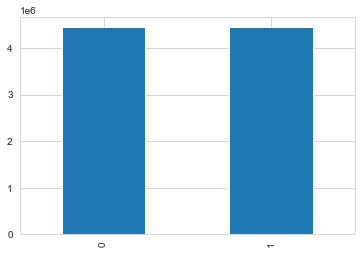

In [6]:
oversample = SMOTE()
# ravel will convert our data to numpy array
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train.ravel())
pd.Series(y_train_oversampled).value_counts().plot.bar() # we will show chart to show, that the data were oversampled and balanced into 50/50 ratio.

train_unique_label_oversample, train_counts_label_oversample = np.unique(y_train_oversampled, return_counts=True) 

print('Training set size after oversampling: ', train_counts_label_oversample)
print('Proportion of non-fake and fake transactions in training after oversampling: ') # the ratio is now 50/50
print(train_counts_label_oversample/ len( y_train_oversampled))

In [7]:
# we will convert the X_train back to dataframe and fill it with oversampled data
X_train = pd.DataFrame(X_train_oversampled, columns=X_train.columns)
# we will also convert the numpy array of isFraud column into dataframe
oversampled_y_train = pd.DataFrame(y_train_oversampled, columns=["isFraud"])
oversampled_y_train.shape

(8896130, 1)

In [8]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,258,3601.66,32072.00,28470.34,0.00,0.00
1,9,50920.02,7090452.48,7141372.49,92608.00,41687.98
2,12,160998.14,1203020.27,1364018.41,4588606.28,4224505.69
3,161,25230.52,174690.00,149459.48,0.00,0.00
4,188,15067.94,0.00,0.00,0.00,0.00


In [9]:
# since the isFraud column is missing from X_train, we will concat the the dataframes and create one big oversampled dataframe
X_train = pd.concat([X_train, oversampled_y_train], axis=1, join='inner')

In [10]:
# now that all of our data are in the same dataframe, we can save that dataframe into csv 
# and start applying MLlib methods on our dataset
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,258,3601.66,32072.00,28470.34,0.00,0.00,0
1,9,50920.02,7090452.48,7141372.49,92608.00,41687.98,0
2,12,160998.14,1203020.27,1364018.41,4588606.28,4224505.69,0
3,161,25230.52,174690.00,149459.48,0.00,0.00,0
4,188,15067.94,0.00,0.00,0.00,0.00,0


In [11]:
X_train.to_csv("oversampled_dataset.csv")

# Data exploration

In [20]:
os_df = pd.read_csv("oversampled_dataset.csv")

In [21]:
os_df.info()
os_df = os_df.drop("Unnamed: 0", axis='columns')
os_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8896130 entries, 0 to 8896129
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   step            int64  
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(3)
memory usage: 543.0 MB


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,258,3.601660e+03,3.207200e+04,28470.34,0.000000e+00,0.000000e+00,0
1,9,5.092002e+04,7.090452e+06,7141372.49,9.260800e+04,4.168798e+04,0
2,12,1.609981e+05,1.203020e+06,1364018.41,4.588606e+06,4.224506e+06,0
3,161,2.523052e+04,1.746900e+05,149459.48,0.000000e+00,0.000000e+00,0
4,188,1.506794e+04,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0
...,...,...,...,...,...,...,...
8896125,29,7.480687e+04,7.480687e+04,0.00,0.000000e+00,0.000000e+00,1
8896126,37,1.164390e+06,1.164390e+06,0.00,0.000000e+00,0.000000e+00,1
8896127,112,7.248264e+05,7.248264e+05,0.00,0.000000e+00,0.000000e+00,1
8896128,263,7.538943e+04,7.538943e+04,0.00,0.000000e+00,7.538943e+04,1


In [22]:
os_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,8.896130e+06,8.896130e+06,8.896130e+06,8.896130e+06,8.896130e+06,8.896130e+06,8896130.0
mean,3.066437e+02,8.222201e+05,1.234837e+06,5.172056e+05,8.118170e+05,1.241195e+06,0.5
std,1.728851e+02,1.865167e+06,3.186521e+06,2.434178e+06,2.809204e+06,3.295083e+06,0.5
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.820000e+02,3.723845e+04,1.069900e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,2.990000e+02,1.721126e+05,1.181400e+05,0.000000e+00,0.000000e+00,1.230820e+05,0.5
75%,4.050000e+02,5.420142e+05,8.045981e+05,0.000000e+00,5.110645e+05,1.083800e+06,1.0
max,7.430000e+02,9.244552e+07,5.039905e+07,4.367380e+07,3.560159e+08,3.561793e+08,1.0


In [18]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [19]:
missing_data(os_df)

,Unnamed: 0,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
Total,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,float64,float64,float64,float64,float64,int64


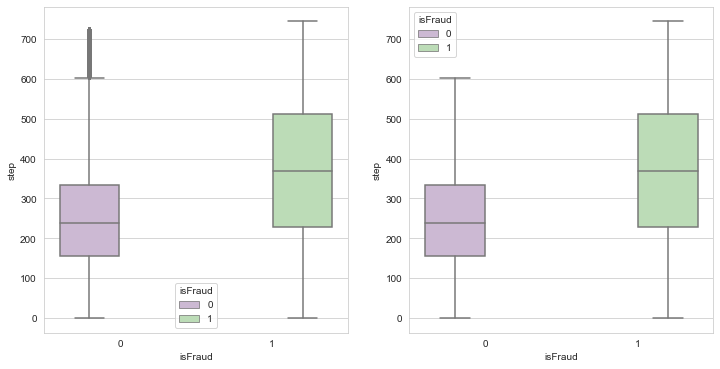

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="isFraud", y="step", hue="isFraud",data=os_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="isFraud", y="step", hue="isFraud",data=os_df, palette="PRGn",showfliers=False)
plt.show()

# Using MLlib pyspark methods on balanced dataset
    - we will create spark session on our local system using all cores of CPU
    - then we will read the csv
    - we will remove unnecessary columns
    - create assemblerand evaluator
    - then we will run multiple methods of Spark MLlib
    - we will time the methods to see which one is the fastest(also for comparison reasons)
    - after we ran them, we will visualize the results and compare some of the methods

In [12]:
# session on local machine using all cores
spark = SparkSession.builder.master("local[*]")\
        .config("spark.executor.memory", "16g")\
        .config("spark.driver.memory", "16g")\
        .config("spark.memory.offHeap.enabled", True)\
        .config("spark.memory.offHeap.size","7g")\
        .appName("ModelCompare")\
        .getOrCreate()
df = spark.read.option("inferSchema","true").option("header","true").csv("oversampled_dataset.csv") # read dataset(oversampled)

# check the data inside of dataframe and check the dimensions
df.show(n=5)
print("Shape of dataframe: ", (df.count(), len(df.columns)))

+---+----+---------+-------------+--------------+--------------+--------------+-------+
|_c0|step|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|
+---+----+---------+-------------+--------------+--------------+--------------+-------+
|  0| 280|487262.34|          0.0|           0.0|    2451858.97|    2939121.31|      0|
|  1| 357|211860.42|     41131.51|           0.0|     567304.68|      779165.1|      0|
|  2| 285| 96251.13|   4428519.02|    4524770.15|    1636873.96|    1540622.83|      0|
|  3|  15|  8699.94|     45558.81|      36858.87|           0.0|           0.0|      0|
|  4| 235| 10232.96|     217272.0|     227504.96|     530861.66|      520628.7|      0|
+---+----+---------+-------------+--------------+--------------+--------------+-------+
only showing top 5 rows

Shape of dataframe:  (8896054, 8)


In [13]:
# remove the unnecesarry columns if there are any(they might not be present in oversampled dataset)
col_to_drop = ['_c0', 'type', 'nameOrig','nameDest']
df = df.drop(*col_to_drop)
trainDf, testDf = df.randomSplit([0.7,0.3],40)

In [14]:
# Vector assembler is used to combine numerical columns into 1 vector column
assembler = VectorAssembler(inputCols=["step", "amount", "oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"], outputCol='features')
# vectorized testing and training dataframes for cross validation
df_tr = VectorAssembler.transform(assembler, trainDf)
df_vector_test = VectorAssembler.transform(assembler, testDf)
df_tr = df_tr.select(['features', 'isFraud'])
# We are using binary evaluator because our label can have only values between 1 and 0
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

# Usage of ML methods on our dataset

## Logistic Regression

In [15]:
%%time
lrmodel = LogisticRegression(featuresCol = 'features', labelCol = 'isFraud', maxIter=10)
lr_pipe = Pipeline(stages=[assembler,lrmodel])
lr_trained = lr_pipe.fit(trainDf)
lr_predictions = lr_trained.transform(testDf)
print('LogisticRegression Test Area Under ROC', evaluator.evaluate(lr_predictions))

LogisticRegression Test Area Under ROC 0.8881780555805892
CPU times: total: 46.9 ms
Wall time: 24.8 s


### Logistic Regression - cross validation 

In [16]:
%%time
paramGrid = ParamGridBuilder()\
.addGrid(lrmodel.regParam, [0.1, 0.01])\
.addGrid(lrmodel.fitIntercept, [False, True])\
.addGrid(lrmodel.elasticNetParam, [0.0, 0.5, 1.0])\
.build()

crossval = CrossValidator()\
        .setEstimator(lrmodel)\
        .setEvaluator(BinaryClassificationEvaluator().setLabelCol("isFraud"))\
        .setEstimatorParamMaps(paramGrid)\
        .setNumFolds(10)\
        .setParallelism(4)
cvModel = crossval.fit(df_tr)

CPU times: total: 6.38 s
Wall time: 11min 15s


In [17]:
lr_cvPredictionDf = cvModel.transform(df_vector_test)
cvAccuracy = evaluator.evaluate(lr_cvPredictionDf)
print("Logistic Regression cross validation Accuracy: ", str(round(cvAccuracy * 100, 2)), "%")

Logistic Regression cross validation Accuracy:  89.9 %


## Random Forest

In [18]:
%%time
rfmodel = RandomForestClassifier(featuresCol = 'features', labelCol = 'isFraud', impurity='gini', maxDepth=5, maxBins=32)
rf_pipe = Pipeline(stages=[assembler,rfmodel])
rf_trained = rf_pipe.fit(trainDf)
rf_predictions = rf_trained.transform(testDf)
print('RandomForest Test Area Under ROC', evaluator.evaluate(rf_predictions))

RandomForest Test Area Under ROC 0.9935030329095966
CPU times: total: 15.6 ms
Wall time: 35.5 s


### Random Forest - cross validation

In [19]:
%%time
paramGrid = ParamGridBuilder()\
  .addGrid(RandomForestClassifier.maxBins, [25, 28, 32])\
  .addGrid(RandomForestClassifier.maxDepth, [5, 8, 10])\
  .addGrid(RandomForestClassifier.impurity, ["entropy", "gini"])\
  .build()

crossval = CrossValidator()\
        .setEstimator(rfmodel)\
        .setEvaluator(BinaryClassificationEvaluator().setLabelCol("isFraud"))\
        .setEstimatorParamMaps(paramGrid)\
        .setNumFolds(10)\
        .setParallelism(4)
cvModel = crossval.fit(df_tr)

CPU times: total: 10.2 s
Wall time: 48min 35s


In [20]:
rf_cvPredictionDf = cvModel.transform(df_vector_test)
cvAccuracy = evaluator.evaluate(rf_cvPredictionDf)
print("Random Forest cross validation Accuracy: ", str(round(cvAccuracy * 100, 2)), "%")

Random Forest cross validation Accuracy:  99.35 %


## Gradient boosted trees

In [87]:
%%time
gbtmodel = GBTClassifier(featuresCol="features", labelCol="isFraud", maxIter=10)
gbt_pipe = Pipeline(stages=[assembler,gbtmodel])
gbt_trained = gbt_pipe.fit(trainDf)
gbt_predictions = gbt_trained.transform(testDf)
print('GBT Test Area Under ROC', evaluator.evaluate(gbt_predictions))

GBT Test Area Under ROC 0.9968090735844247
CPU times: total: 15.6 ms
Wall time: 52.4 s


### Gradient Boosted Trees - cross validation 

In [22]:
%%time
paramGrid = ParamGridBuilder()\
             .addGrid(GBTClassifier.maxDepth, [2, 5, 10])\
             .addGrid(GBTClassifier.maxBins, [10, 20, 40])\
             .addGrid(GBTClassifier.maxIter, [5, 10, 20])\
             .build()

crossval = CrossValidator()\
        .setEstimator(gbtmodel)\
        .setEvaluator(BinaryClassificationEvaluator().setLabelCol("isFraud"))\
        .setEstimatorParamMaps(paramGrid)\
        .setNumFolds(10)\
        .setParallelism(4)
cvModel = crossval.fit(df_tr)

CPU times: total: 20.4 s
Wall time: 3h 5min 20s


In [23]:
dt_cvPredictionDf = cvModel.transform(df_vector_test)
cvAccuracy = evaluator.evaluate(dt_cvPredictionDf)
print("Gradient Boosted Tree cross validation Accuracy: ", str(round(cvAccuracy * 100, 2)), "%")

Gradient Boosted Tree cross validation Accuracy:  99.68 %


## Decision Tree 

In [191]:
%%time
dtmodel = DecisionTreeClassifier(featuresCol="features", labelCol="isFraud", maxDepth = 5, impurity = 'gini')
dt_pipe = Pipeline(stages=[assembler,dtmodel])
dt_trained = dt_pipe.fit(trainDf)
dt_predictions = dt_trained.transform(testDf)
print('Decision Tree Test Area Under ROC', evaluator.evaluate(dt_predictions))

Decision Tree Test Area Under ROC 0.9771242334800959
CPU times: total: 31.2 ms
Wall time: 25.9 s


### Decision Tree - cross validation

In [192]:
%%time
paramGrid = ParamGridBuilder()\
             .addGrid(DecisionTreeClassifier.maxDepth, [2, 5, 10, 20, 30])\
             .addGrid(DecisionTreeClassifier.maxBins, [10, 20, 40, 80, 100])\
             .addGrid(DecisionTreeClassifier.impurity, ["entropy", "gini"])\
             .build()

crossval = CrossValidator()\
        .setEstimator(dtmodel)\
        .setEvaluator(BinaryClassificationEvaluator().setLabelCol("isFraud"))\
        .setEstimatorParamMaps(paramGrid)\
        .setNumFolds(10)\
        .setParallelism(4)
cvModel = crossval.fit(df_tr)

CPU times: total: 25 s
Wall time: 43min 1s


In [193]:
dt_cvPredictionDf = cvModel.transform(df_vector_test)
cvAccuracy = evaluator.evaluate(dt_cvPredictionDf)
print("Decision Tree cross validation Accuracy: ", str(round(cvAccuracy * 100, 2)), "%")

Decision Tree cross validation Accuracy:  97.71 %


## Linear support vector classifier 

In [194]:
%%time
svcmodel = LinearSVC(featuresCol="features", labelCol="isFraud")
svc_pipe = Pipeline(stages=[assembler,svcmodel])
svc_trained = svc_pipe.fit(trainDf)
svc_predictions = svc_trained.transform(testDf)
print('SVC Test Area Under ROC', evaluator.evaluate(svc_predictions))

SVC Test Area Under ROC 0.9776356851889816
CPU times: total: 0 ns
Wall time: 1min 4s


### Linear support vector classifier - cross validation 

In [28]:
%%time
paramGrid = ParamGridBuilder()\
             .addGrid(LinearSVC.maxIter, [10, 20])\
             .addGrid(LinearSVC.regParam,[0.001, 0.01, 1])\
             .build()

crossval = CrossValidator()\
        .setEstimator(svcmodel)\
        .setEvaluator(BinaryClassificationEvaluator().setLabelCol("isFraud"))\
        .setEstimatorParamMaps(paramGrid)\
        .setNumFolds(10)\
        .setParallelism(4)
cvModel = crossval.fit(df_tr)

CPU times: total: 2.66 s
Wall time: 40min 41s


In [29]:
svc_cvPredictionDf = cvModel.transform(df_vector_test)
cvAccuracy = evaluator.evaluate(svc_cvPredictionDf)
print("Support vector classifier cross validation Accuracy: ", str(round(cvAccuracy * 100, 2)), "%")

Support vector classifier cross validation Accuracy:  98.18 %


# Visualization of used ML methods

## Visualization of Logistic Regression metrics

In [150]:
lr_summary = lr_trained.stages[-1].summary
lr_roc = lr_summary.roc.toPandas()
lr_pr = lr_summary.pr.toPandas()
print(lr_summary.fMeasureByLabel())

[0.8340624258520225, 0.8028104706633628]


C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


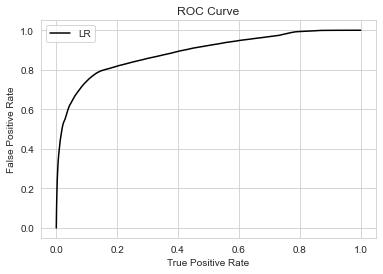

LogisticRegression Training set areaUnderROC: 0.8879679916716612


In [48]:
plt.plot(lr_roc['FPR'],lr_roc['TPR'],color="black", label = "LR")
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print('LogisticRegression Training set areaUnderROC: ' + str(lr_summary.areaUnderROC))

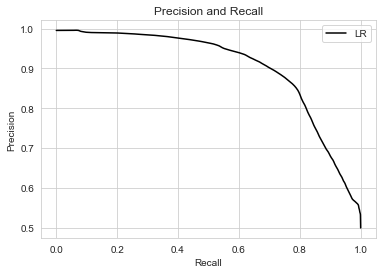

In [153]:
plt.plot(lr_pr['recall'],lr_pr['precision'],color="black", label = "LR")
plt.title('Precision and Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

## Visualization of Random Forest Metrics

In [197]:
rf_summary = rf_trained.stages[-1].summary
rf_roc = rf_summary.roc.toPandas()
rf_pr = rf_summary.pr.toPandas()
print(rf_summary.fMeasureByLabel())

[0.9565160104379571, 0.9565840284027921]


C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


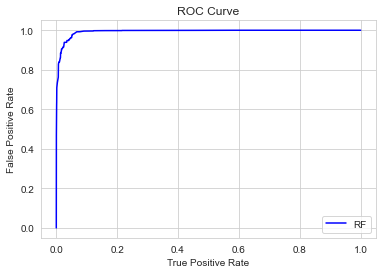

RandomForest Training set areaUnderROC: 0.9934628341091417


In [54]:
plt.plot(rf_roc['FPR'],rf_roc['TPR'],color="blue", label = "RF")
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print('RandomForest Training set areaUnderROC: ' + str(rf_summary.areaUnderROC))

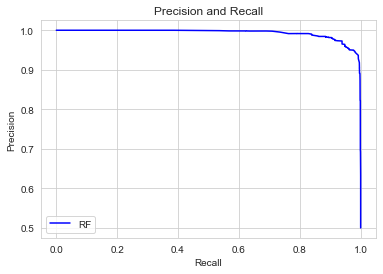

In [154]:
plt.plot(rf_pr['recall'],rf_pr['precision'],color="blue", label = "RF")
plt.title('Precision and Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

In [34]:
print('LogisticRegression Test Area Under ROC', evaluator.evaluate(lr_predictions))
print('RandomForest Test Area Under ROC', evaluator.evaluate(rf_predictions))
print('GBT Test Area Under ROC', evaluator.evaluate(gbt_predictions))
print('DecisionTree Test Area Under ROC', evaluator.evaluate(dt_predictions))
print('SVC Test Area Under ROC', evaluator.evaluate(svc_predictions))

LogisticRegression Test Area Under ROC 0.8881782660812017
RandomForest Test Area Under ROC 0.9935030329095966
GBT Test Area Under ROC 0.9968090735844247
DecisionTree Test Area Under ROC 0.9887492310585476
SVC Test Area Under ROC 0.9818316570070365


# sklearn Machine Learning Methods for comparisson with MLlib Apache Spark

In [42]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from statistics import mean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [30]:
df = pd.read_csv("oversampled_dataset.csv")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']], df['isFraud'], test_size= 0.3)

In [34]:
rf_clf=RandomForestClassifier(n_estimators = 5)

## sklearn Random Forest

In [35]:
%%time
rf_clf.fit(X_train,y_train)
y_pred=rf_clf.predict(X_test)

CPU times: total: 1min 21s
Wall time: 1min 22s


In [40]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf_clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), np.std(n_scores)))

Accuracy: 0.999 (0.000)


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1335521
           1       1.00      1.00      1.00   1333307

    accuracy                           1.00   2668828
   macro avg       1.00      1.00      1.00   2668828
weighted avg       1.00      1.00      1.00   2668828



## sklearn SVC

In [50]:
%%time
svc = LinearSVC(max_iter=100, dual=True)
svc.fit(X_train, y_train)
ypred = svc.predict(X_test)
score = svc.score(X_train, y_train)
print(score)

C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8384518515211671
CPU times: total: 1min 32s
Wall time: 1min 32s


In [49]:
cm = confusion_matrix(y_test, ypred)
print(cm)

cr = classification_report(y_test, ypred)
print(cr)

[[1177287  156617]
 [ 104752 1230170]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90   1333904
           1       0.89      0.92      0.90   1334922

    accuracy                           0.90   2668826
   macro avg       0.90      0.90      0.90   2668826
weighted avg       0.90      0.90      0.90   2668826



## sklearn GBT classifier

In [41]:
%%time
gbt = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, max_depth=3, random_state=0).fit(X_train, y_train)
gbt.score(X_test, y_test)
gbt_ypred = gbt.predict(X_test)

CPU times: total: 1min 15s
Wall time: 1min 15s


In [157]:
cr = classification_report(y_test, gbt_ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98   1335521
           1       0.98      0.99      0.98   1333307

    accuracy                           0.98   2668828
   macro avg       0.98      0.98      0.98   2668828
weighted avg       0.98      0.98      0.98   2668828



In [158]:
cm = confusion_matrix(y_test, gbt_ypred)
print(cm)

[[1301640   33881]
 [   7946 1325361]]


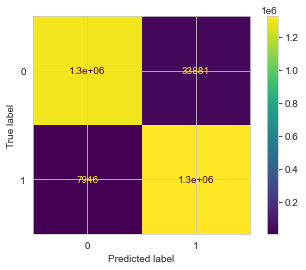

In [161]:
plot_confusion_matrix(gbt, X_test, y_test)  

Text(0.5, 1.0, '2-class Precision-Recall curve')

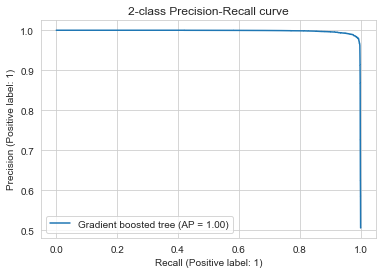

In [163]:
display = PrecisionRecallDisplay.from_estimator(gbt, X_test, y_test, name="Gradient boosted tree")
display.ax_.set_title("2-class Precision-Recall curve ")

## sklearn Decision Tree Classifier

In [38]:
%%time
dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)
dt_ypred = dt_clf.predict(X_test)

CPU times: total: 28.1 s
Wall time: 28.1 s


In [170]:
cr = classification_report(y_test, dt_ypred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1335521
           1       0.94      1.00      0.97   1333307

    accuracy                           0.97   2668828
   macro avg       0.97      0.97      0.97   2668828
weighted avg       0.97      0.97      0.97   2668828



[[1256051   79470]
 [   4827 1328480]]


C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


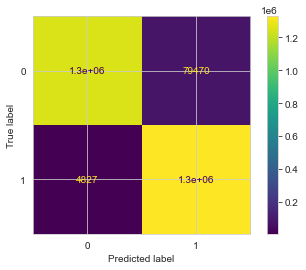

In [171]:
cm = confusion_matrix(y_test, dt_ypred)
print(cm)
plot_confusion_matrix(dt_clf, X_test, y_test)

Text(0.5, 1.0, '2-class Precision-Recall curve')

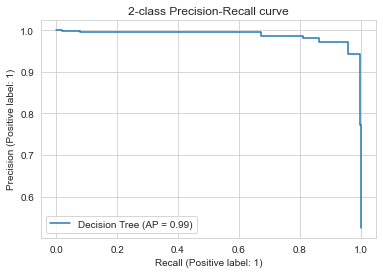

In [173]:
display = PrecisionRecallDisplay.from_estimator(dt_clf, X_test, y_test, name="Decision Tree")
display.ax_.set_title("2-class Precision-Recall curve")

## sklearn Logistic Regression

In [45]:
%%time
lr_clf = LogisticRegression(random_state=0, max_iter = 10).fit(X_train, y_train)
score = lr_clf.score(X_test, y_test)
lr_ypred = lr_clf.predict(X_test)

C:\Users\ondru\.virtualenvs\spark_test-ZVXdXnIM\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 26.6 s
Wall time: 10.5 s


In [46]:
print(score)

0.9172849784886687
